In [24]:
import numpy as np
import pandas as pd
import bt
import matplotlib.pyplot as plt
%matplotlib inline

from Algo_Helpers import Signal, WeighFromSignal, Rebalance
start_date = '2010-11-01'


In [25]:
pdf = bt.get('aapl,msft,c,ge,gs', start=start_date)
#pdf = pdf.pct_change(1) # 1 for ONE DAY lookback


In [50]:
pdf.info()
#pdf.isna().sum()
#pdf.eq(0).any()
#float(0) in pdf.values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2959 entries, 2010-11-01 to 2022-08-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aapl    2959 non-null   float64
 1   msft    2959 non-null   float64
 2   c       2959 non-null   float64
 3   ge      2959 non-null   float64
 4   gs      2959 non-null   float64
dtypes: float64(5)
memory usage: 138.7 KB


In [51]:
runMonthlyAlgo = bt.algos.RunWeekly()
rebalAlgo = Rebalance()

In [66]:
signalAlgo = Signal(pd.DateOffset(months=2),pd.DateOffset(days=1))
#signalAlgo = Signal()



In [67]:
weighFromSignalAlgo = WeighFromSignal()

In [68]:
s = bt.Strategy(
    'example1',
    [
        runMonthlyAlgo,
        signalAlgo,
        weighFromSignalAlgo,
        rebalAlgo
    ]
)
s.perm['tickers'] = list(pdf.columns)
t = bt.Backtest(s, pdf, integer_positions=False, progress_bar=True)
res = bt.run(t)

example1
0% [############################# ] 100% | ETA: 00:00:00

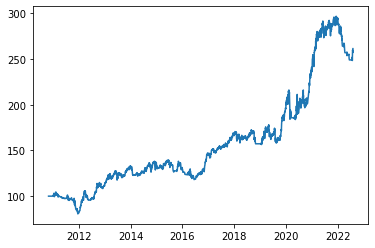

In [69]:
plt.plot(res.prices)
#pr = res.prices

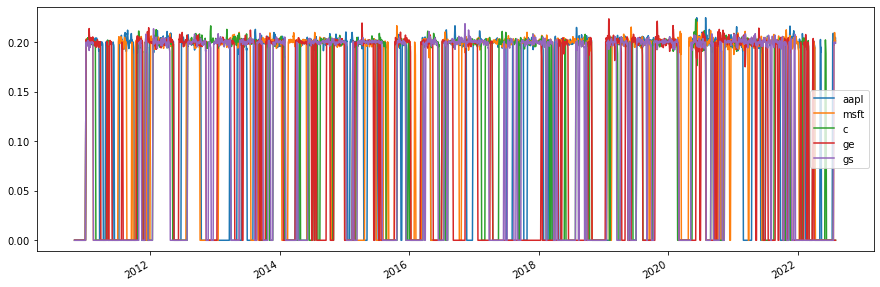

In [70]:
res.plot_security_weights()
#res.prices.tail()
#temp = res.get_security_weights()
#test = res.get_transactions()
#q = t.positions

In [71]:
df = pdf['aapl']

tmt = res.get_security_weights()['aapl']
tmt = tmt.rename("weight")
tmt = tmt.drop(tmt.index[0])
rdf = pd.concat([df, tmt], axis=1)
rdf['label'] = np.where(rdf['weight'] == 0, -1, 1)

""


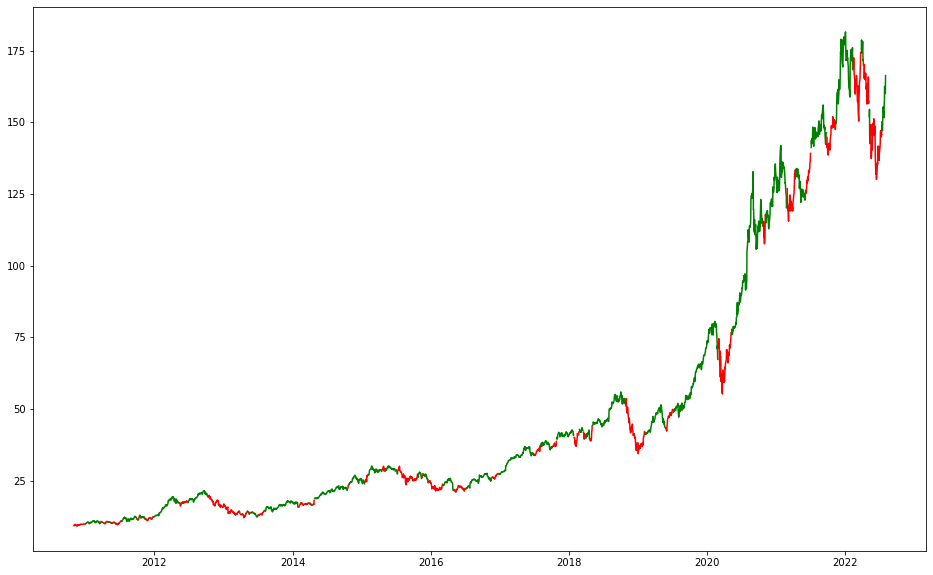

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
def plot_func(group):
    global ax
    color = 'r' if (group['label'] < 0).all() else 'g'
    lw = 1.5
    ax.plot(group.index, group.aapl, c=color, linewidth=lw)


rdf.groupby((rdf['label'].shift() * rdf['label'] < 0).cumsum()).apply(plot_func)


In [73]:
res.stats


,example1
start,2010-10-31 00:00:00
end,2022-08-03 00:00:00
rf,0.0
total_return,1.613726
cagr,0.085156
max_drawdown,-0.228227
calmar,0.373122
mtd,0.005859
three_month,0.017423
six_month,-0.07483
